# Stock Predictor
LSTM architecture to predict Stockprices based on [this Kaggle Dataset](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


In [28]:
%matplotlib inline
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
import matplotlib
import time
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
torch.manual_seed(1)

<Figure size 432x288 with 0 Axes>

In [37]:
csv = pd.read_csv('./googl.us.txt')
csv.drop(columns=["OpenInt", "Date"], inplace=True)
data = torch.tensor(csv.values, dtype=torch.float)
data = data[:-3]
print(data.size()[0])

3330


In [38]:
for column in range(5):
    data[:, column] /= torch.max(data[:, column])
    data[:, column] -= data[:, column].mean()

In [76]:
class StockPredictor(nn.Module):
    def __init__(self, layers):
        super(StockPredictor, self).__init__()
        self.layers = layers
        self.lstm = nn.LSTM(5, 1, 1)
        self.lstms = [nn.LSTM(10, 10) for _ in range(layers-1)]
        self.lstms.insert(0, nn.LSTM(5, 10, 1))
        self.final = nn.Linear(10, 1)
        self.activation = nn.LeakyReLU()
    def forward(self, stock, keep_hidden_state=False, batches=10):
        if not keep_hidden_state:
            self.hidden = [(torch.zeros(1, batches, 10),
                       torch.zeros(1, batches, 10))for _ in range(self.layers)] + [(torch.zeros(1, batches, 1),
                       torch.zeros(1, batches, 1))]
        out = torch.zeros(stock.size()[0], 1, 10)
        for i, lstm in enumerate(self.lstms):
            if i != 0:
                out, self.hidden[i] = lstm(out, self.hidden[i])
            else:
                out, self.hidden[i] = lstm(stock, self.hidden[i])
            #out = self.activation(out)
        out = self.final(out)
        return out

In [94]:
model = StockPredictor(3)
optim = torch.optim.Adam(model.parameters(), lr=0.1)
loss_function = nn.MSELoss()

In [45]:
#load ignore if you want a new model
model.load_state_dict(torch.load("./model.sav"))
model.eval()

RuntimeError: Error(s) in loading state_dict for StockPredictor:
	Missing key(s) in state_dict: "final.weight", "final.bias". 
	Unexpected key(s) in state_dict: "final.weight_ih_l0", "final.weight_hh_l0", "final.bias_ih_l0", "final.bias_hh_l0". 

KeyboardInterrupt: 

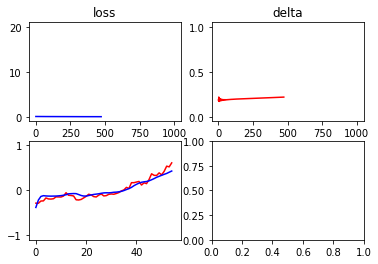

In [95]:
test_seperate = 3000
epochs = 1000
batches = 60
losses = []
deltas = []
fig, ((lax, dax), (cmpax, _)) = plt.subplots(ncols=2, nrows=2)
lplot, = lax.plot([0, epochs], [20, 0], 'b')
lax.set_title("loss")
dplot, = dax.plot([0, epochs], [1, 0], 'r')
dax.set_title("delta")
rplot, = cmpax.plot([0, (data.size()[0]-30)/batches], [-1, 1], 'r')
pplot, = cmpax.plot([0, (data.size()[0]-30)/batches], [-1, 1], 'b')
for epoch in range(epochs):
    model.zero_grad()
    inputs = data[:-30, :].view(-1, batches, 5) #inferring length of the sequence
    target = data[30:, 3].view(-1, batches)
    prediction = model.forward(inputs, batches=batches)
    loss = ((prediction[:, 0] - target)**2).mean()#\
        #+ ((1/(prediction[20:]-prediction[:-20])**2)*torch.arange(1, target.size()[0]-20, dtype=torch.float32)*0.1).mean()
    loss.backward()
    optim.step()
    delta = (prediction - data[30:, 3]).abs().mean()
    # visualising learning progress
    deltas.append(np.asscalar(delta.detach().numpy()))
    losses.append(np.asscalar(loss.detach().numpy()))
    lplot.set_data(range(epoch+1), losses)
    dplot.set_data(range(epoch+1), deltas)
    rplot.set_data(range(target.size()[0]), target[:, epoch % batches].detach().numpy())
    pplot.set_data(range(target.size()[0]), prediction[:, epoch % batches].detach().numpy())
    clear_output(wait=True)
    display(fig)
    print(f'\r{epoch}: {delta} | {loss.detach()}')
    # uncomment for seeing the gradients
#     for lstm in model.lstms:
#         print(lstm.weight_ih_l0)
#         print(lstm.weight_hh_l0)
#         print(lstm.bias_ih_l0.grad)
#         print(lstm.bias_hh_l0.grad)
#     lstm = model.final
#     print(lstm.weight.grad)

#     print(lstm.bias.grad)

    #time.sleep(5)
    
    
plt.show()    
    

In [ ]:
#saving
torch.save(model.state_dict(), "./model.sav")

tensor([-0.2990, -0.2879, -0.2834, -0.2826, -0.2771, -0.2697, -0.2816, -0.2843,
        -0.2781, -0.2643, -0.2485, -0.2376, -0.2314, -0.2288, -0.2344, -0.2295,
        -0.2228, -0.2258, -0.1841, -0.1714, -0.1651, -0.1585, -0.1945, -0.1910,
        -0.2075, -0.1788, -0.1825, -0.1887, -0.1855, -0.1682, -0.1915, -0.1902,
        -0.1767, -0.1724, -0.1387, -0.1362, -0.1406, -0.1511, -0.1328, -0.1485,
        -0.1538, -0.1509, -0.1407, -0.1481, -0.1290, -0.1193, -0.1062, -0.1247,
        -0.1293, -0.1101, -0.0728, -0.0340, -0.0561, -0.0401, -0.0614, -0.1083,
        -0.1281, -0.1607, -0.1537, -0.1119, -0.0938, -0.1005, -0.1190, -0.1472,
        -0.1319, -0.1488, -0.1659, -0.1976, -0.1955, -0.2359, -0.2201, -0.2202,
        -0.2081, -0.2058, -0.2106, -0.1995, -0.1839, -0.1812, -0.1661, -0.1758,
        -0.1576, -0.1513, -0.1507, -0.1330, -0.1076, -0.1026, -0.0896, -0.0843,
        -0.0896, -0.1175, -0.1168, -0.1050, -0.0911, -0.1293, -0.1432, -0.1317,
        -0.1530, -0.1395, -0.1476, -0.14

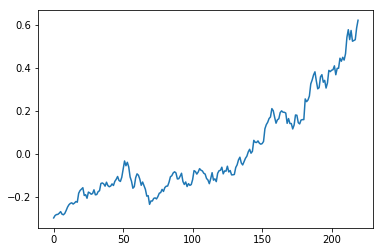

In [90]:
plt.plot(target[:, 11].numpy())
print(target[:, 11])
plt.show()